# Predicting Credit Card Fraud - A Tour of Basic Classification Techniques

In this project, we will explore data relating to fraudulent credit card transactions. We will run through basic techniques of data exploration and pre-processing, as well as attempt to build a simple model to predict fraudulent transaction using basic regression techniques. The open dataset used for this notebook was obtained from Kaggle (https://www.kaggle.com/dalpozz/creditcardfraud). Below is a breakdown of the processes that will be outlined in this notebook:

### Contents
    1. Dataset Exploration
    2. Visualiztion
    3. Data Pre-Processing
    4. Classification Models
        1. Logistic Regression

The objective for the models we will build is as follows:

### Problem Description
Predict fraudulent credit card transactions using anonymized transaction data.

Let's begin!

## 1. Data Exploration

We first begin by loading in the necessary packages for the data analysis

In [1]:
# for general handling and manipulation of table data
import pandas as pd
import numpy as np

# for generation of interactive data visualization
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# for building classifier model predictions and result analysis
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve
import itertools

# start a random seed for reproducibility of results
np.random.seed(1)

Next we will load the data and get a sense of the general structure of information available

In [2]:
data = pd.read_csv('creditcard.csv')

In [3]:
print('data({0[0]},{0[1]})'.format(data.shape))

print('Number of training examples: {0}'.format(data.shape[0]))
print('Number of features for each example: {0}'.format(data.shape[1]))

data(284807,31)
Number of training examples: 284807
Number of features for each example: 31


Below is a list of the labels for each of the 31 data features

In [4]:
pd.DataFrame(data = {'Feature Label': data.columns})

,Feature Label
0,Time
1,V1
2,V2
3,V3
4,V4
5,V5
6,V6
7,V7
8,V8
9,V9


The data has the following feature structure within its 31 features:

    Time - Time that the transaction occurred in seconds (time span for this dataset is 48 hours total: 172,800 seconds)
    V1-V28 - Anonymized credit card transaction data
    Amount - Amount of the transaction
Class - Label describing whether transaction was fraudulent or genuiune

We are also given the information from Porto Seguro that missing data in this dataset is marked by a '-1' value. Any columns with a '-1' value present are listed below along with the number of missing entries for each of these columns.

In [5]:
pd.DataFrame(data = {'# of Missing Data Entries': data.isnull().sum()})

,# of Missing Data Entries
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


Lucky! So far we don't have any evidence of missing data entries, but sometimes datasets encode missing entries differently, such as with '-1' entries, dashes '-', blank spaces ' ', etc. so we will be on the lookout for these types of outliers as we explore the features.

## 2. Visualization

Let's now begin to visualize different aspects of the data to see what we can learn about the information contained in the features we've been given.

Starting off we will look at the class variable, which is the main feature of interest we are asked to predict. The pie graph below shows the relative distribution of the target variable.

In [6]:
labels = ["Genuine", "Fraudulent"]
values = data["Class"].value_counts().values

trace = go.Pie(labels = labels, values = values)
layout = go.Layout(title = 'Distribution of Class Feature')

fig = go.Figure(data = [trace], layout = layout)
iplot(fig)

As we can see, the class variable is highly skewed, with only 0.173% of transactions being fraudulent. In order to properly evaluate the performance of our model, we will need to use a specialized metric that accounts for false positive and false negative predictions since a model that simply predicts all transactions as genuine would (on the surface) be over 99.8% accurate!

Next we will take a look at the distribution of the Time feature in our data:

In [7]:
# Distribution of time feature, divided by 3600 seconds to view data in hours
(data['Time']/3600.0).describe()

count    284807.000000
mean         26.337183
std          13.191152
min           0.000000
25%          15.055972
50%          23.525556
75%          38.700139
max          47.997778
Name: Time, dtype: float64

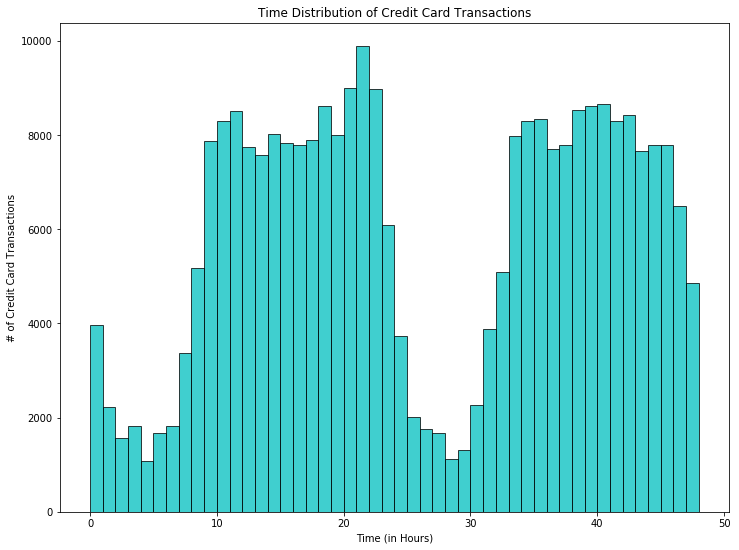

In [8]:
# Initialize figure
plt.figure(figsize = (12,9))

# Add histogram data
plt.hist(data['Time']/3600,
         bins = 48,
         facecolor='c',
         edgecolor = 'k',
         alpha=0.75,
        )

# Figure formatting
plt.xlabel('Time (in Hours)')
plt.ylabel('# of Credit Card Transactions')
plt.title('Time Distribution of Credit Card Transactions')
plt.rcParams.update({'font.size': 18})

# plot!
plt.show()

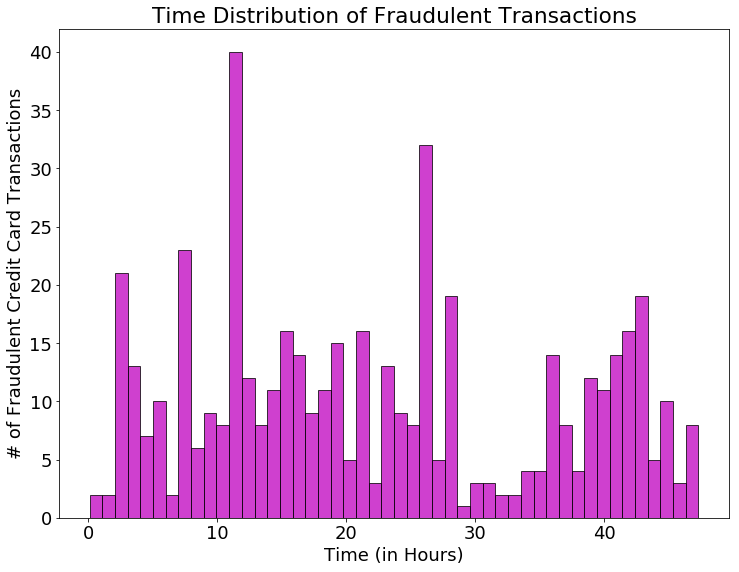

In [9]:
# Initialize figure
plt.figure(figsize = (12,9))

# Add histogram data
plt.hist(data['Time'][data['Class'] == 1]/3600,
         bins = 48,
         facecolor='m',
         edgecolor = 'k',
         alpha=0.75,
        )

# Figure formatting
plt.xlabel('Time (in Hours)')
plt.ylabel('# of Fraudulent Credit Card Transactions')
plt.title('Time Distribution of Fraudulent Transactions')
plt.rcParams.update({'font.size': 18})

# plot!
plt.show()

Although there are some peaks in the time data relating to fraudulent transactions, it's difficult to tell at a glance if there is a trend that will help us with our predictions.

Next we will take a look at the Amount feature.

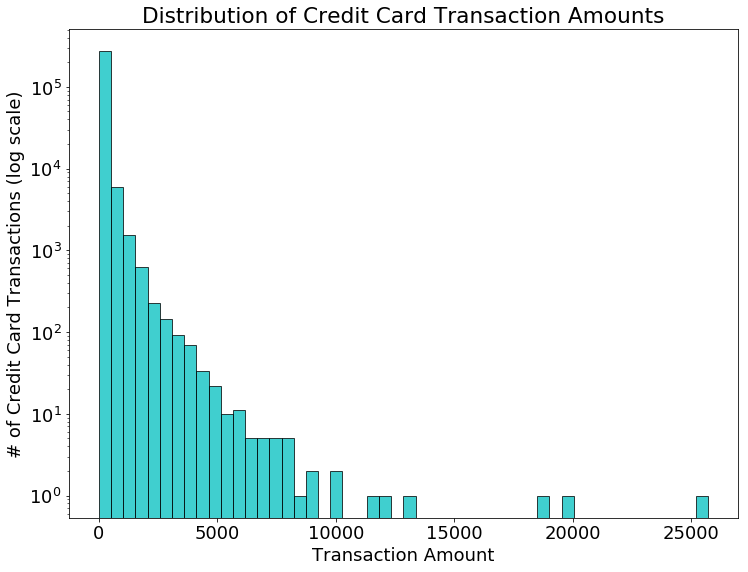

In [10]:
# Initialize figure
plt.figure(figsize = (12,9))

# Add histogram data
plt.hist(data['Amount'],
         bins = 50,
         facecolor='c',
         edgecolor = 'k',
         alpha=0.75,
         log = True
        )

# Figure formatting
plt.xlabel('Transaction Amount')
plt.ylabel('# of Credit Card Transactions (log scale)')
plt.title('Distribution of Credit Card Transaction Amounts')
plt.rcParams.update({'font.size': 18})

# plot!
plt.show()

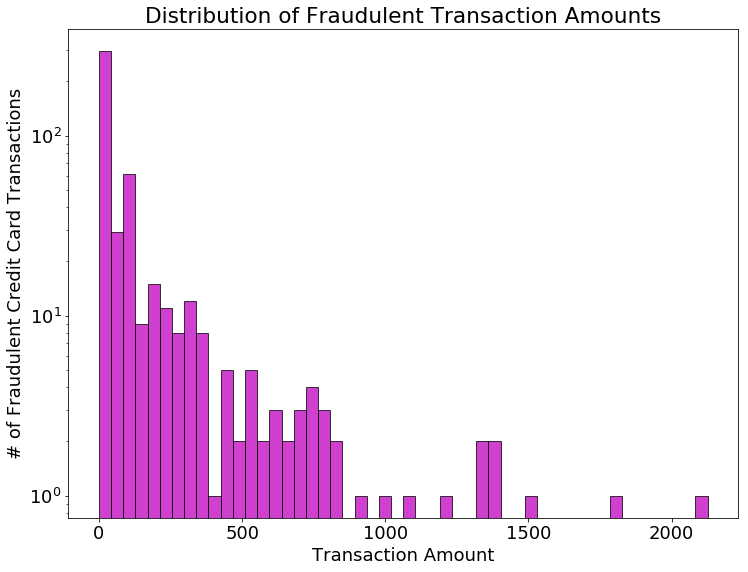

In [11]:
# Initialize figure
plt.figure(figsize = (12,9))

# Add histogram data
plt.hist(data['Amount'][data['Class'] == 1],
         bins = 50,
         facecolor='m',
         edgecolor = 'k',
         alpha=0.75,
         log = True
        )

# Figure formatting
plt.xlabel('Transaction Amount')
plt.ylabel('# of Fraudulent Credit Card Transactions')
plt.title('Distribution of Fraudulent Transaction Amounts')
plt.rcParams.update({'font.size': 18})

# plot!
plt.show()

Here we can see that while the fradulent transaction trend is similar to the overall trend, it drops off much more rapidly, and we typically don't see any fraudulent transactions above ~$1,000 with the exception of a few outliers.

### 3. Data Pre-processing

Let's begin preparing our data to build our predictive models. To start, we will split the training data into training ("train") and cross-validation ("CV") sets. The data will be split with the following distribution:

    90% train
    10% CV

In [12]:
# Split test set from data
X_temp, X_test, y_temp, y_test = train_test_split(data.drop(['Class'], axis = 1), data['Class'], test_size=0.2, random_state=42)

# Split remaining data into train and CV sets
X_train, X_CV, y_train, y_CV = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Verify train, CV and test sets
print('Number of training entries: {0} -> {1:.0f}% of data'.format(X_train.shape[0], 100*X_train.shape[0]/data.shape[0]))
print('Number of CV entries: {0} -> {1:.0f}% of data'.format(X_CV.shape[0], 100*X_CV.shape[0]/data.shape[0]))
print('Number of test entries: {0} -> {1:.0f}% of data'.format(X_test.shape[0], 100*X_test.shape[0]/data.shape[0]))

Number of training entries: 170883 -> 60% of data
Number of CV entries: 56962 -> 20% of data
Number of test entries: 56962 -> 20% of data


Before we get started, we want to make sure that both our training and cross-validation sets contain a distribution of genuine and fraudulent transactions.

In [13]:
# Create labels and counts of genuine and fraudulent transactions for all data subsets
labels = ['Genuine', 'Fraudulent']
train_values = y_train.value_counts().values
CV_values = y_CV.value_counts().values
test_values = y_test.value_counts().values

# Create interactive pie charts for each subset
trace1 = go.Pie(labels =  labels,
                values = train_values,
                domain= {"x": [0, 0.3]},
                hole = 0.5
               )

trace2 = go.Pie(labels = labels,
                values = CV_values,
                domain= {"x": [0.35, 0.65]},
                hole = 0.5
               )

trace3 = go.Pie(labels = labels,
                values = test_values,
                domain= {"x": [0.70, 1]},
                hole = 0.5
               )

# Plot formatting
layout = go.Layout(title = 'Distribution of Class Feature',
                    annotations = [{"text": "Train",
                                    "font": {"size": 20},
                                    "showarrow": False,
                                    "x": 0.11,
                                    "y": 0.5
                                   },
                                   {"text": "CV",
                                    "font": {"size": 20},
                                    "showarrow": False,
                                    "x": 0.5,
                                    "y": 0.5
                                   },
                                   {"text": "Test",
                                    "font": {"size": 20},
                                    "showarrow": False,
                                    "x": 0.88,
                                    "y": 0.5
                                   },
                                  ]
                   )

# Plot!
fig = go.Figure(data = [trace1, trace2, trace3], layout = layout)
iplot(fig)

## 4. Classification Models

### 4.1 Logistic Regression

Now that we have separated our data, we can begin building our logistic regression model to predict fraudulent transactions given our data. In order to avoid overfitting and choose the best features for our model we will use best subset selection, which was covered in Regression Fundamentals \#1. Below is an example of best subset selection for the top 5 ranked features for our data prediction.

In [14]:
# Select number of features for subset
K = 5
subset = SelectKBest(k = K)
subset.fit(X_train, y_train)

# Display selected subset features
pd.DataFrame(data = {'Subset Features': X_train.columns[subset.get_support()]})

,Subset Features
0,V10
1,V12
2,V14
3,V16
4,V17


In order to choose the appropriate number of features we will combine the best subset selection method with cross-validation and a threshold of 50%, which means any predicted probability of fraud above 50% will result in a Fradulent transaction prediction.

In [15]:
# Initialize list for CV_errors and logistic regression model (with normalization)
CV_scores = []
lm = LogisticRegression()

for K in range(1, len(X_train.columns) + 1):
    # Create best subset of K features
    subset = SelectKBest(k = K)
    subset.fit(X_train, y_train)
    X_train_subset = X_train[X_train.columns[subset.get_support()].values.tolist()]
    
    # Perform logistic regression on selected features
    fit = lm.fit(X_train_subset, y_train)
    predict = lm.predict(X_CV[X_train.columns[subset.get_support()].values.tolist()])
    
    # Calculate classification error
    score = f1_score(y_CV, predict*1)
    CV_scores.append(score)

for our model evaluation metric we will be using F1 score, which is calculated as follows:
    F1 = 2 * (precision * recall) / (precision + recall)
where **precision** is the fraction of true positives divided by the total number of true positives and false positive fradulent values and **recall** represents the number of true positives divided by the number of true positives and false negative values.

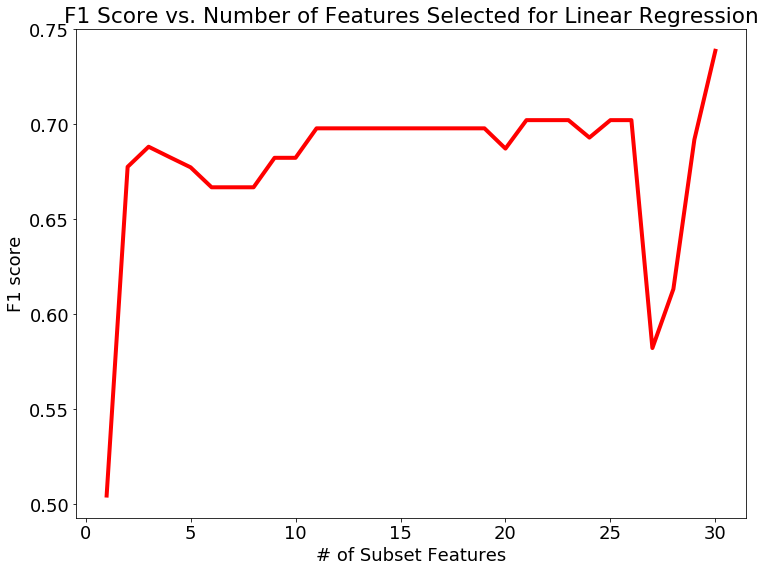

In [16]:
# Plot CV error vs. number of selected features
plt.figure(figsize = (12,9))
plt.plot(range(1, len(X_train.columns)+1),
         CV_scores,
         linewidth = 4,
         c = 'r'
        )

# Plot formatting
plt.xlabel('# of Subset Features')
plt.ylabel('F1 score')
plt.title('F1 Score vs. Number of Features Selected for Linear Regression')
plt.rcParams.update({'font.size': 18})

# Plot!
plt.show()

By looking at our F1 scores we can determine which subset to use, but since it looks like using all of our available features has yielded the highest F1 score so far we will proceed with the full set of features. We can visualize the accuracy of our model by looking directly at a confusion matrix, which will show us the rate of False positives or false negatives that our model has returned.

In [17]:
# Perform logistic regression on full feature set
lm = LogisticRegression()
fit = lm.fit(X_train, y_train)
predict = lm.predict(X_CV)

cnf_matrix = confusion_matrix(y_CV, predict)

The following function will plot visualizations for our confusion matrices. This was sourced from sci-kit learn documentation for confusion_matrix. Please see: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html for more details

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    NOTE: This code was sourced from Sci-kit learn documentation,
    see: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html for more details
    """

    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

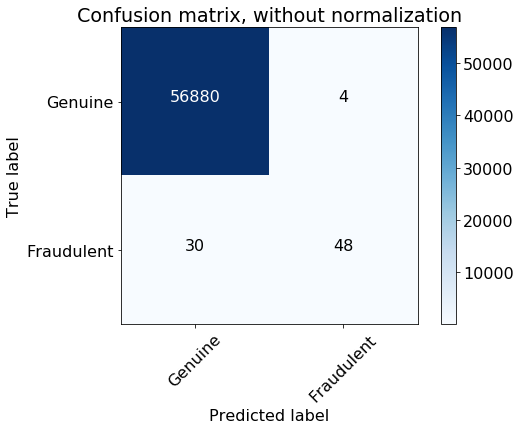

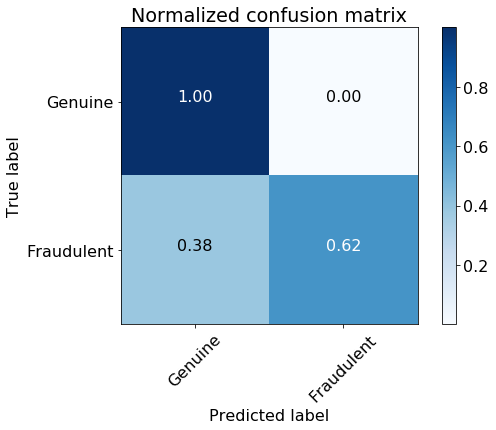

In [19]:
# Plot non-normalized confusion matrix
plt.rcParams.update({'font.size': 16})
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['Genuine', 'Fraudulent'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['Genuine', 'Fraudulent'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Although we can see that our model performs quite well on predicting genuine transactions, as expected we still have room to improve with respect to our Fraudulent transaction predictions, since only ~62% of Fraudulent transactions in our CV were predicted by the model.

One approach we can take is to vary the threshold at which we will predict Fraud. With a lower prediction threshold, we may catch more fraudulent transactions at the expense of misclassifying some genuine transactions. The balance between these two is generally dependent on the task we are trying to achieve, but it seems sensible to try and catch more fraudulent transactions, even if that means catching some genuine transactions by our model.

Below is a precision-recall curve, which shows the balance between both precision and recall with the variation of our threshold.

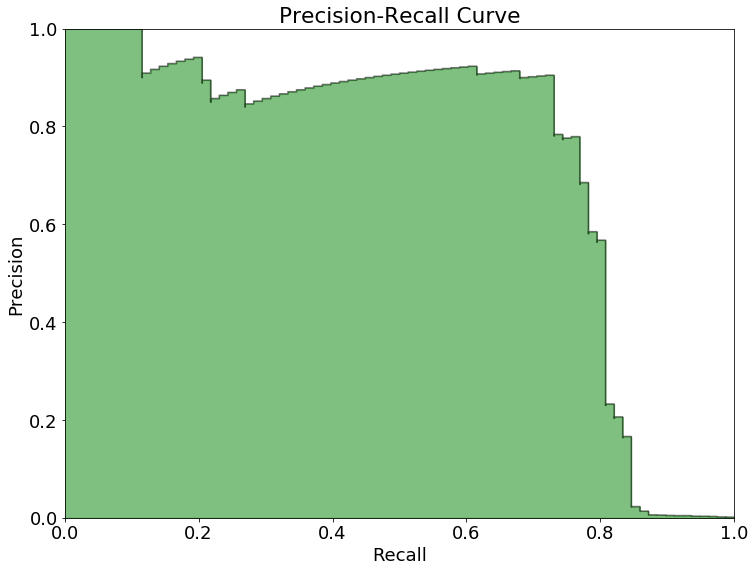

In [20]:
# Perform logistic regression on full feature set
lm = LogisticRegression()
fit = lm.fit(X_train, y_train)
predict = lm.predict_proba(X_CV)

# Generate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_CV, predict[:,1])

plt.rcParams.update({'font.size': 18})
plt.figure(figsize = (12,9))
plt.step(recall, precision, color='k', alpha=0.5,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.5,
                 color='g')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title('Precision-Recall Curve')

plt.show()

Looking at the curve above, we should be able to achieve a higher combination of precision and recall accuracy, which would make an improvement to our model. We can choose the threshold which achieves the highest F1 score using the following:

In [21]:
F1_scores = []

for threshold in np.arange(0, 1, 0.01):
    CV_class = 1*(predict[:,1] >= threshold)
    F1_scores.append(f1_score(y_CV, CV_class))

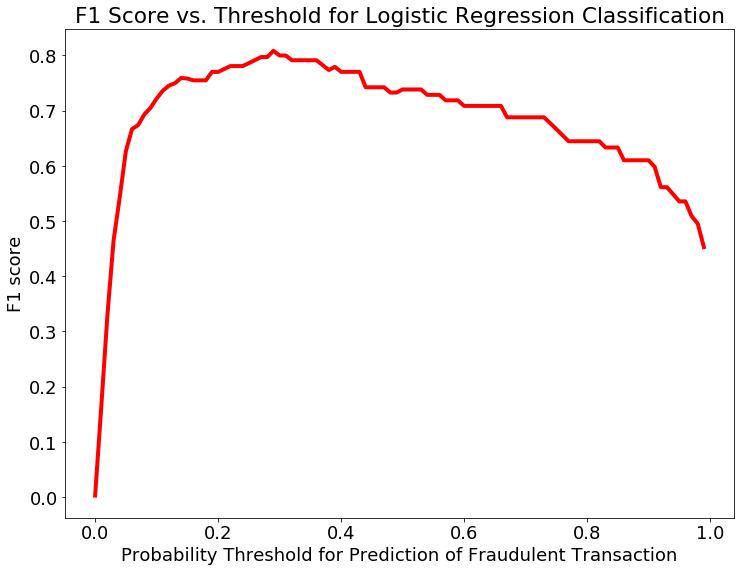

In [22]:
# Plot CV error vs. number of selected features
plt.figure(figsize = (12,9))
plt.plot(np.arange(0,1,0.01),
         F1_scores,
         linewidth = 4,
         c = 'r'
        )

# Plot formatting
plt.xlabel('Probability Threshold for Prediction of Fraudulent Transaction')
plt.ylabel('F1 score')
plt.title('F1 Score vs. Threshold for Logistic Regression Classification')
plt.rcParams.update({'font.size': 18})

# Plot!
plt.show()

Now we can use the threshold with the maximum score to re-frame our predictions.

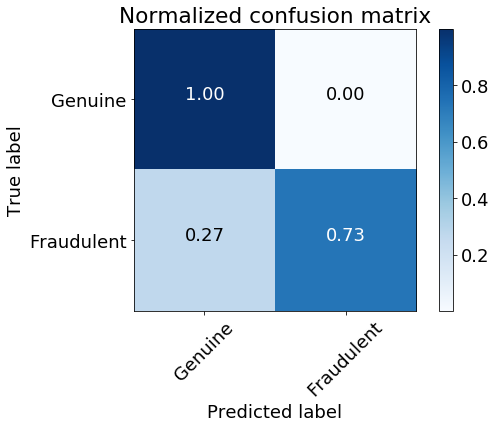

In [23]:
CV_class = 1*(predict[:,1] >= (np.argmax(F1_scores)*.01))
cnf_matrix = confusion_matrix(y_CV, CV_class)

# Plot normalized confusion matrix
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['Genuine', 'Fraudulent'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

We can see from the confusion matrix that we were able increase our True positive rate of fraud detection in our CV dataset to about ~73%. Now that we've performed some optimization, we can test the accuracy on our test dataset.

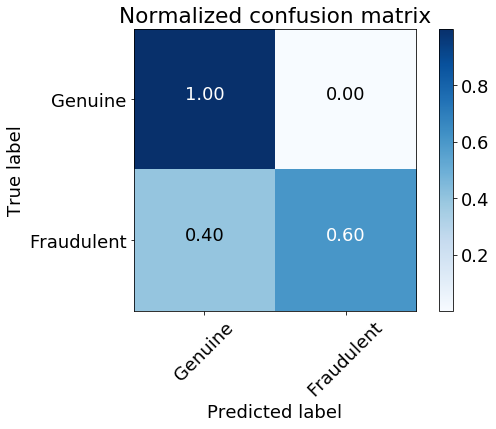

In [24]:
# Use the model to make predictions onthe test set
predict = lm.predict_proba(X_test)

# Generate Confusion Matrix
test_class = 1*(predict[:,1] >= (np.argmax(F1_scores)*.01))
cnf_matrix = confusion_matrix(y_test, test_class)

# Plot normalized confusion matrix
plt.figure(figsize = (8,6))
plot_confusion_matrix(cnf_matrix,
                      classes=['Genuine', 'Fraudulent'],
                      normalize=True,
                      title='Normalized confusion matrix')

# Plot!
plt.show()

This covers some of the fundamental techniques of classification, although the performance on our test set suggests that there may still room for improvement to increase the accuracy of predictions.

### Thank you for reading!